In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2025-04-09 16:37:23.470959: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-09 16:37:27.182299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744209448.376858   24209 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744209448.702495   24209 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744209451.690830   24209 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Found GPU at: /device:GPU:0


I0000 00:00:1744209508.179923   24209 gpu_device.cc:2019] Created device /device:GPU:0 with 13499 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [160]:
train_ds, train_info = tfds.load('speech_commands', split='train', shuffle_files=True, as_supervised=True, with_info=True)
val_ds, val_info = tfds.load('speech_commands', split='validation', shuffle_files=True, as_supervised=True, with_info=True)
test_ds, test_info = tfds.load('speech_commands', split='test', shuffle_files=True, as_supervised=True, with_info=True)

In [54]:
for example in train_ds.take(1):
    print(example)

(<tf.Tensor: shape=(16000,), dtype=int16, numpy=array([ -19, -119, -220, ..., -127, -156, -177], dtype=int16)>, <tf.Tensor: shape=(), dtype=int64, numpy=6>)


In [164]:
class_names = train_info.features['label'].names
print("Original class names:", class_names)

Original class names: ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']


In [57]:
labels = [example[1] for example in train_ds]
print(len(labels))

85511


['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']


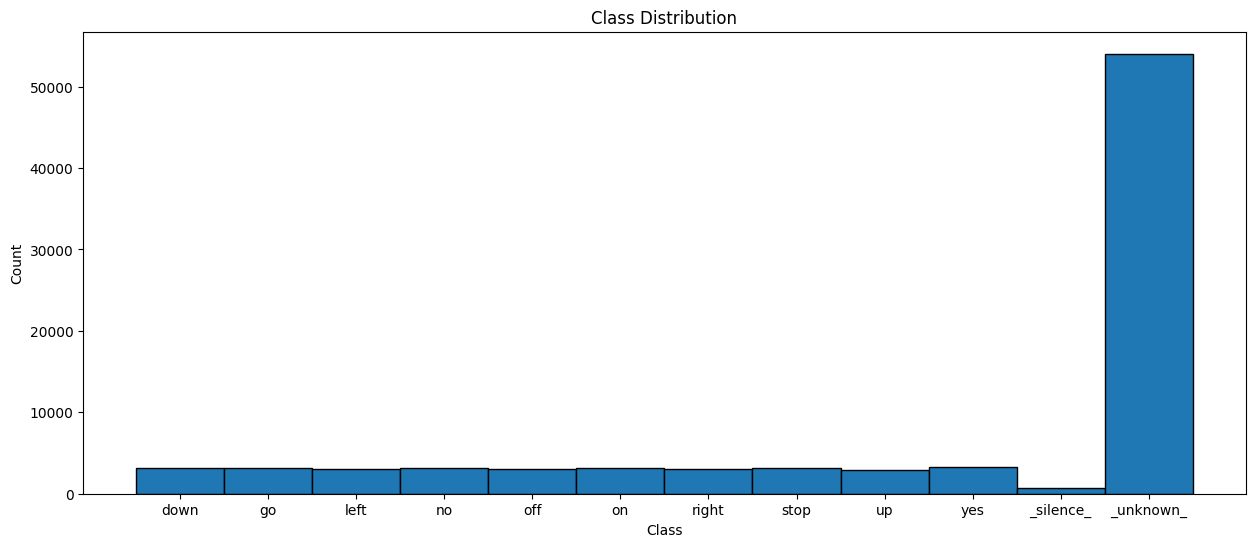

In [165]:
print(class_names)
n_classes = len(class_names)
bin_edges = np.arange(-0.5, n_classes)

plt.figure(figsize=(15, 6))
plt.hist(labels, bins=bin_edges, edgecolor='black')
plt.xticks(ticks=range(len(class_names)), labels=class_names, ha='center')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [166]:
new_label_indexes = [0, 2, 6, 8, 10, 11]  # Original indices for ['down', 'left', 'right', 'up', '_silence_', '_unknown_']
labels_to_keep = tf.constant(new_label_indexes, dtype=tf.int64)
new_class_names = ['down', 'left', 'right', 'up', '_silence_', '_unknown_']
n_classes = len(new_class_names)

# Filter the dataset to keep only the desired labels
filtered_train_ds = train_ds.filter(
    lambda audio, label: tf.reduce_any(tf.math.equal(labels_to_keep, label))
)

In [167]:
# Create a lookup table to remap original labels to new consecutive indices
# E.g., 0 -> 0, 2 -> 1, 6 -> 2, 8 -> 3, 10 -> 4, 11 -> 5
label_mapping = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(new_label_indexes, dtype=tf.int64),
        values=tf.constant(list(range(len(new_label_indexes))), dtype=tf.int64)
    ),
    default_value=-1  # Return -1 for labels not in new_label_indexes (though filter ensures this won't happen)
)

# Map the dataset to remap labels
def remap_labels(audio, label):
    new_label = label_mapping.lookup(label)
    return audio, new_label

remapped_train_ds = filtered_train_ds.map(remap_labels)

In [169]:
# Collect labels for plotting
new_labels = []
for _, label in remapped_train_ds:
    new_labels.append(label.numpy())  # Convert each label tensor to NumPy

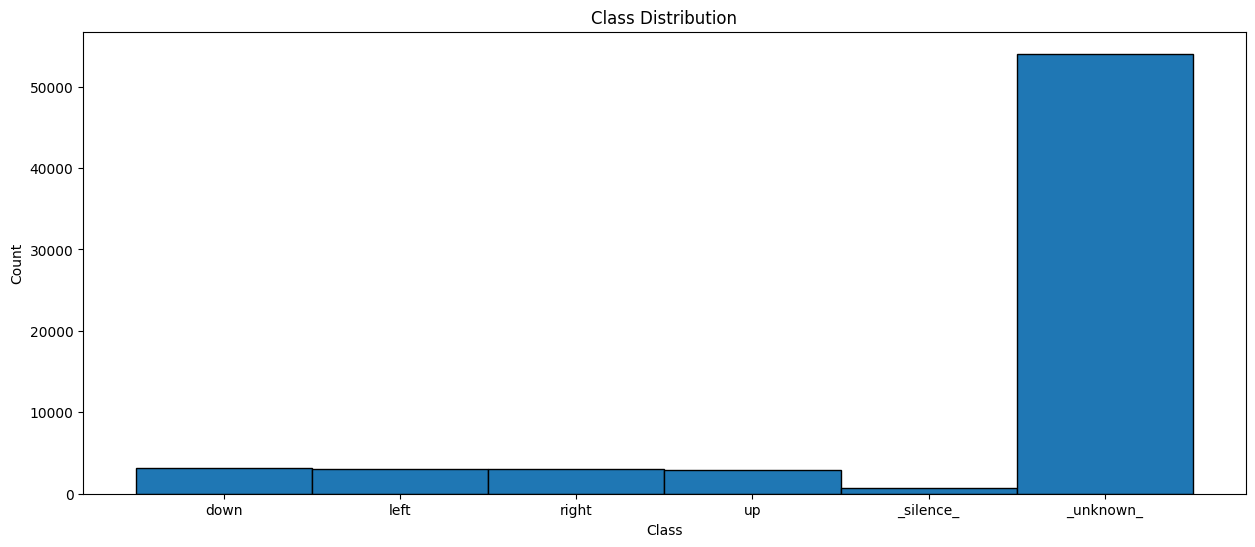

In [170]:
# Create the histogram
bin_edges = np.arange(-0.5, n_classes)  # Bins: [-0.5, 0.5, 1.5, ..., 5.5]
plt.figure(figsize=(15, 6))
plt.hist(new_labels, bins=bin_edges, edgecolor='black')
plt.xticks(ticks=range(n_classes), labels=new_class_names, ha='center')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [183]:
filtered_val_ds = val_ds.filter(
    lambda audio, label: tf.reduce_any(tf.math.equal(labels_to_keep, label))
)

filtered_test_ds = test_ds.filter(
    lambda audio, label: tf.reduce_any(tf.math.equal(labels_to_keep, label))
)

remapped_val_ds = filtered_val_ds.map(remap_labels)
remapped_test_ds = filtered_test_ds.map(remap_labels)

In [70]:
import IPython.display as ipd  # Import for audio playback

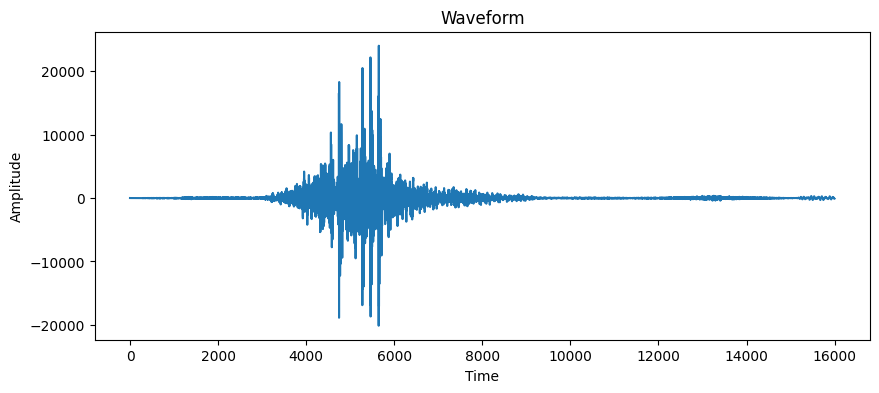

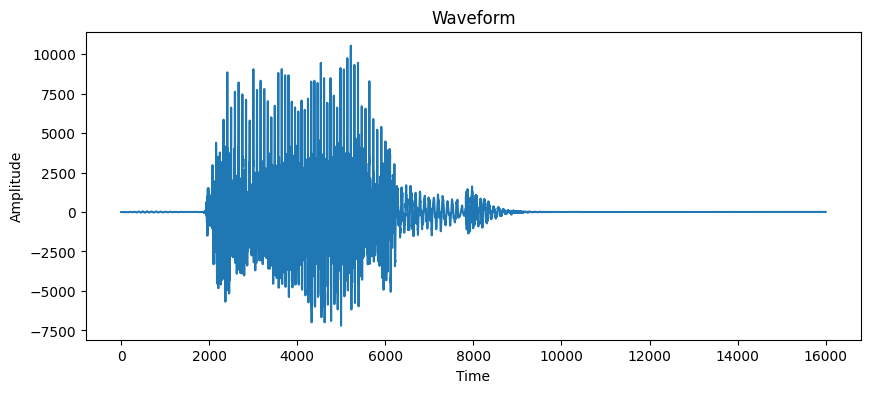

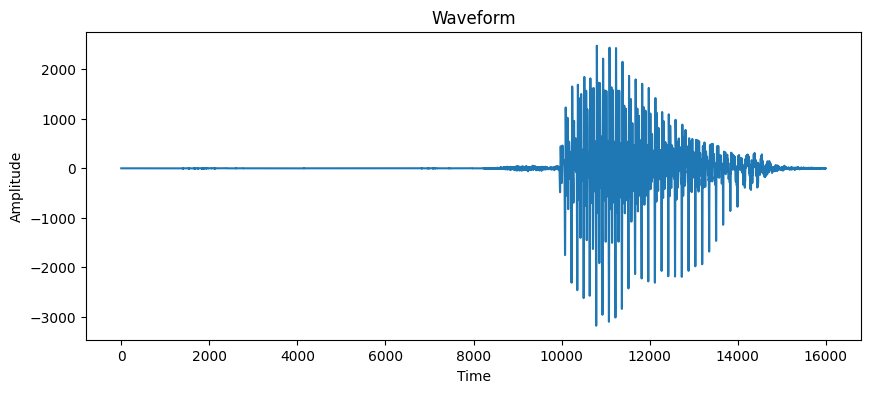

In [172]:
for example in train_ds.take(3):
  # Access the audio waveform and sample rate
  audio = example[0].numpy()
  sample_rate = train_info.features['audio'].sample_rate

  ipd.display(ipd.Audio(audio, rate=sample_rate))

  plt.figure(figsize=(10, 4))
  plt.plot(audio)
  plt.title("Waveform")
  plt.xlabel("Time")
  plt.ylabel("Amplitude")
  plt.show()

In [80]:
def create_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        # Input layer matching the spectrogram shape
        tf.keras.layers.Input(shape=input_shape),
        
        # CNN layers
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten and dense layers - use GlobalAveragePooling2D to avoid reshape issues
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [90]:
def preprocess_dataset(dataset, target_class_ids):
    def preprocess(audio, label):
        #audio = sample[0]
        #label = sample[1]
        
        # Fix length to exactly 16000 samples
        audio = tf.cast(audio, tf.float32)
        target_length = 16000
        
        # Handle variable length audio
        current_length = tf.shape(audio)[0]
        pad_begin = 0
        pad_end = tf.maximum(0, target_length - current_length)
        
        # Pad if needed
        paddings = [[pad_begin, pad_end]]
        audio = tf.pad(audio, paddings)
        
        # Slice if longer than target
        audio = audio[:target_length]
        
        # Compute the spectrogram
        spectrogram = tf.abs(tf.signal.stft(
            audio, frame_length=256, frame_step=128))
        
        # Add channel dimension for Conv2D
        spectrogram = tf.expand_dims(spectrogram, -1)
        
        # Create one-hot encoded labels
        label_index = tf.argmax(tf.equal(label, target_class_ids))
        one_hot = tf.one_hot(label_index, depth=len(target_class_ids))
            
        return spectrogram, one_hot
    
    return dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)


In [82]:
# Check the actual shape of processed data
def inspect_dataset(dataset):
    for spectrogram, label in dataset.take(1):
        print(f"Spectrogram shape: {spectrogram.shape}")
        print(f"Label shape: {label.shape}")
    return spectrogram.shape[1:] # Return the non-batch dimensions


In [184]:
# Prepare datasets
target_class_ids = [class_names.index(cls) for cls in class_names]
#print(f"target_classes: {target_classes}")
#print(f"target_class_ids: {target_class_ids}")
preprocessed_train_ds = preprocess_dataset(remapped_train_ds, target_class_ids).batch(32).prefetch(tf.data.AUTOTUNE)
preprocessed_val_ds = preprocess_dataset(remapped_val_ds, target_class_ids).batch(32)
preprocessed_test_ds = preprocess_dataset(remapped_test_ds, target_class_ids).batch(32)

# Get the actual input shape from the dataset
input_shape = inspect_dataset(preprocessed_train_ds)
print(f"Using input shape: {input_shape}")

# Create and compile model
model = create_model(input_shape, len(class_names))
model.summary()  # Let's see the model architecture
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Add callbacks for early stopping and checkpoints
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

# Train the model
history = model.fit(
    preprocessed_train_ds,
    validation_data=preprocessed_val_ds,
    epochs=30,
    callbacks=callbacks
)

Spectrogram shape: (32, 124, 129, 1)
Label shape: (32, 12)
Using input shape: (124, 129, 1)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 124, 129, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 124, 129, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 62, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 62, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 62, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 31, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 31, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 31, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 15, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,676 (506.55 KB)

 Trainable params: 129,228 (504.80 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
   2005/Unknown 19s 8ms/step - accuracy: 0.8307 - loss: 0.6138

2025-04-09 20:29:01.938898: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
/mnt/c/Users/andre/projects/dat255/dat255-project/venv/tf-gpu-wsl/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-04-09 20:29:01.938956: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.8323 - loss: 0.6059 - val_accuracy: 0.8966 - val_loss: 0.3050
Epoch 2/30
   1/2090 ━━━━━━━━━━━━━━━━━━━━ 2:42 78ms/step - accuracy: 1.0000 - loss: 0.1155

2025-04-09 20:29:05.182075: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:29:05.182130: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2083/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9330 - loss: 0.2030

2025-04-09 20:29:20.185017: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9330 - loss: 0.2030 - val_accuracy: 0.9296 - val_loss: 0.2164
Epoch 3/30
   5/2090 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - accuracy: 0.9501 - loss: 0.1216 

2025-04-09 20:29:21.822102: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:29:21.822159: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9506 - loss: 0.1516

2025-04-09 20:29:33.767968: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:29:33.768067: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9506 - loss: 0.1516 - val_accuracy: 0.9394 - val_loss: 0.1830
Epoch 4/30
   6/2090 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.9634 - loss: 0.0949 

2025-04-09 20:29:35.394258: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:29:35.394316: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9600 - loss: 0.1228

2025-04-09 20:29:50.293475: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:29:50.293572: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9600 - loss: 0.1228 - val_accuracy: 0.8926 - val_loss: 0.3278
Epoch 5/30
  13/2090 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9626 - loss: 0.0883 

2025-04-09 20:29:51.981293: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:29:51.981354: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9627 - loss: 0.1133 - val_accuracy: 0.9554 - val_loss: 0.1472
Epoch 6/30
   6/2090 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.9707 - loss: 0.0758 

2025-04-09 20:30:05.729873: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:30:05.729931: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2088/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9691 - loss: 0.0949

2025-04-09 20:30:20.538469: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:30:20.538529: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9691 - loss: 0.0949 - val_accuracy: 0.9339 - val_loss: 0.1856
Epoch 7/30
  15/2090 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9756 - loss: 0.0895 

2025-04-09 20:30:22.127975: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:30:22.128033: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2088/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9705 - loss: 0.0918

2025-04-09 20:30:33.796400: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:30:33.796455: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9705 - loss: 0.0918 - val_accuracy: 0.9647 - val_loss: 0.1092
Epoch 8/30
   6/2090 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.9542 - loss: 0.1560 

2025-04-09 20:30:35.426279: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:30:35.426336: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2086/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9732 - loss: 0.0803

2025-04-09 20:30:50.484625: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:30:50.484681: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9732 - loss: 0.0803 - val_accuracy: 0.9685 - val_loss: 0.0993
Epoch 9/30
   1/2090 ━━━━━━━━━━━━━━━━━━━━ 3:01 87ms/step - accuracy: 0.9688 - loss: 0.0989

2025-04-09 20:30:52.081401: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:30:52.081459: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9753 - loss: 0.0738 - val_accuracy: 0.9709 - val_loss: 0.0875
Epoch 10/30
   5/2090 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 1.0000 - loss: 0.0249 

2025-04-09 20:31:05.497597: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:31:05.497655: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2087/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9765 - loss: 0.0714

2025-04-09 20:31:20.518915: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:31:20.519017: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9765 - loss: 0.0714 - val_accuracy: 0.9652 - val_loss: 0.1106
Epoch 11/30
  14/2090 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9916 - loss: 0.0471 

2025-04-09 20:31:22.145712: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:31:22.145770: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2083/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9776 - loss: 0.0662

2025-04-09 20:31:33.829779: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:31:33.829881: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9776 - loss: 0.0662 - val_accuracy: 0.9596 - val_loss: 0.1510
Epoch 12/30
  17/2090 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9796 - loss: 0.0545 

2025-04-09 20:31:35.374727: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:31:35.374781: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9776 - loss: 0.0647

2025-04-09 20:31:50.033905: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:31:50.034005: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9776 - loss: 0.0647 - val_accuracy: 0.9534 - val_loss: 0.1600
Epoch 13/30
  15/2090 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9796 - loss: 0.0636 

2025-04-09 20:31:51.586040: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:31:51.586096: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9815 - loss: 0.0566

2025-04-09 20:32:03.246253: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:32:03.246309: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9815 - loss: 0.0566 - val_accuracy: 0.9605 - val_loss: 0.1500
Epoch 14/30
  13/2090 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9904 - loss: 0.0422 

2025-04-09 20:32:04.796556: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:32:04.796614: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2083/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9813 - loss: 0.0557

2025-04-09 20:32:19.579136: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:32:19.579236: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9813 - loss: 0.0557 - val_accuracy: 0.9406 - val_loss: 0.2256


2025-04-09 20:32:21.153288: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9736418459917410555
2025-04-09 20:32:21.153343: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4594531030578727271


In [92]:
def augment_audio(audio):
    # Time shifting
    shift = tf.random.uniform([], -2000, 2000, dtype=tf.int32)
    shifted_audio = tf.roll(audio, shift, axis=0)
    
    # Add noise
    noise_level = tf.random.uniform([], 0.0, 0.01)
    noise = tf.random.normal(tf.shape(audio), stddev=noise_level)
    noisy_audio = audio + noise
    
    # Time stretching or pitch shifting could be added with tfa.image.sparse_image_warp
    
    return tf.cond(tf.random.uniform([]) > 0.5, lambda: shifted_audio, lambda: noisy_audio)

In [181]:
# Plot training history
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm
import seaborn as sns


def plot_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    
    # Plot accuracy
    axs[0].plot(history.history['accuracy'], label='train')
    axs[0].plot(history.history['val_accuracy'], label='validation')
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    
    # Plot loss
    axs[1].plot(history.history['loss'], label='train')
    axs[1].plot(history.history['val_loss'], label='validation')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

# Visualize confusion matrix
def plot_confusion_matrix(model, dataset, class_names):
    y_pred = []
    y_true = []
    
    for x, y in dataset:
        predictions = model.predict(x)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(np.argmax(y, axis=1))
        
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, norm=LogNorm())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

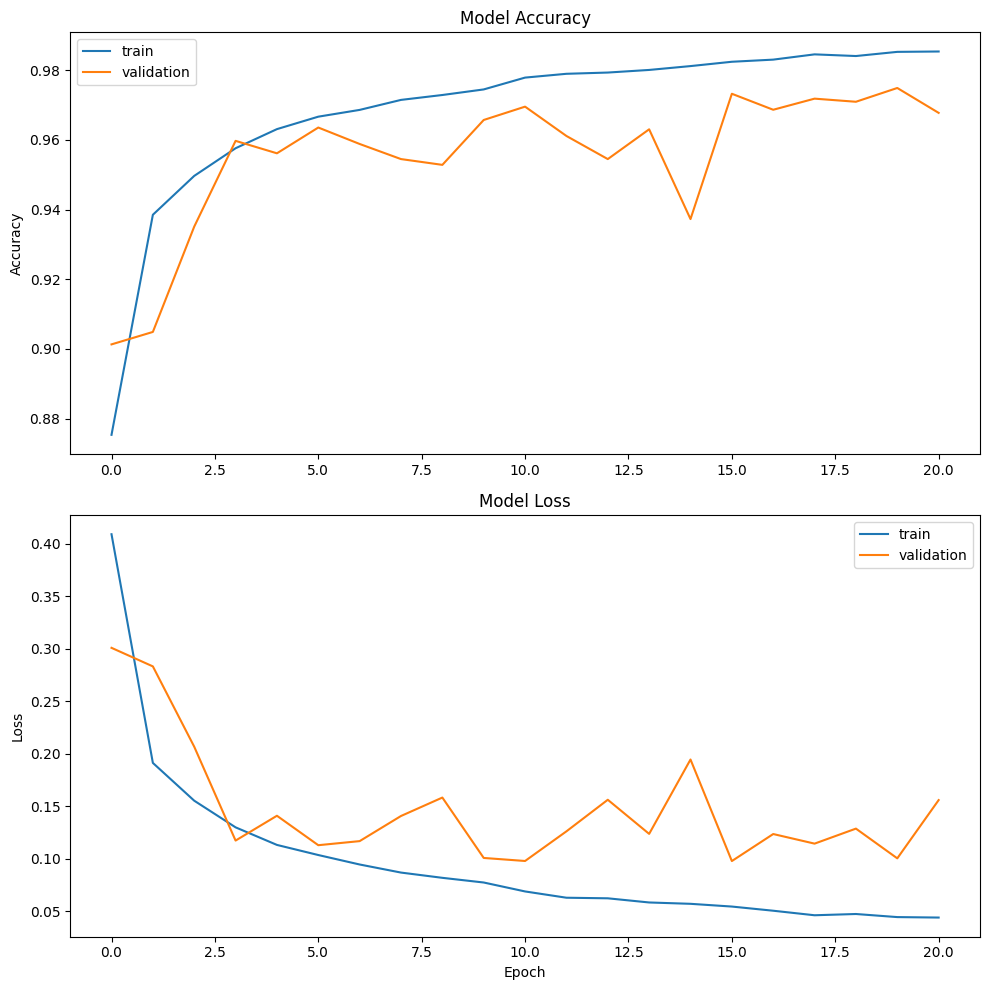

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━

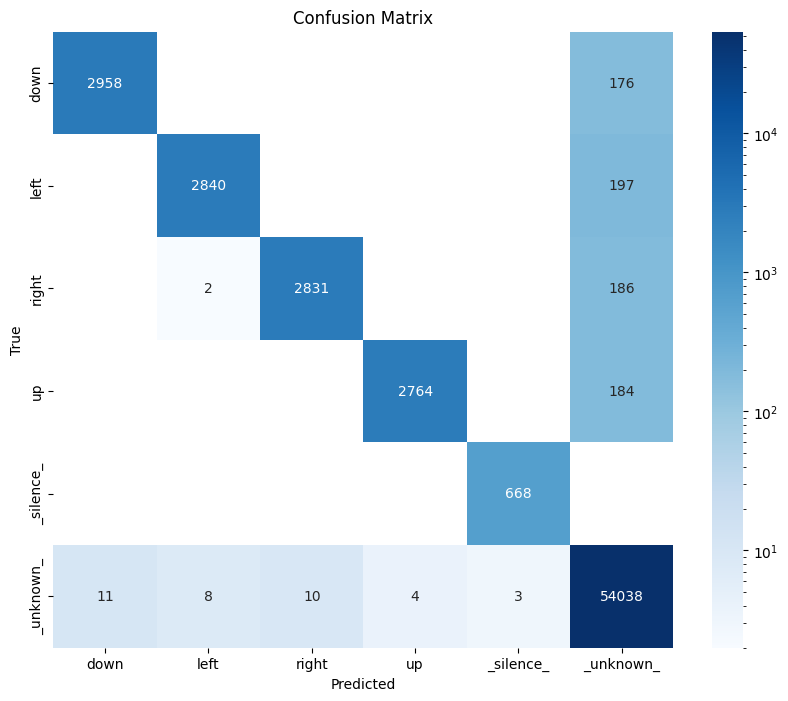

In [182]:
plot_history(history)
plot_confusion_matrix(model, preprocessed_train_ds, new_class_names)


In [ ]:
import tensorflow_hub as hub

def create_transfer_model(num_classes):
    # Load the YAMNet model
    yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')
    
    # Create a new model
    input_layer = tf.keras.layers.Input(shape=(16000,), dtype=tf.float32, name='audio')
    embeddings = yamnet_model(input_layer)['embeddings']
    dense = tf.keras.layers.Dense(128, activation='relu')(embeddings)
    dropout = tf.keras.layers.Dropout(0.5)(dense)
    output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout)
    
    # Create the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [ ]:
def record_and_predict(model, duration=1, sample_rate=16000):
    print("Recording...")
    # Code to record audio using sounddevice or other library
    # Then preprocess and make prediction
    
    # Example (pseudocode):
    # audio = record_audio(duration, sample_rate)
    # processed_audio = preprocess_audio(audio)
    # prediction = model.predict(processed_audio)
    # predicted_class = target_classes[np.argmax(prediction)]
    # return predicted_class

In [ ]:
def evaluate_model(model, preprocessed_test_ds=preprocessed_test_ds):
    # Evaluate the model
    loss, accuracy = model.evaluate(preprocessed_test_ds)
    print(f"Test accuracy: {accuracy:.4f}")
    
    # Get predictions
    all_preds = []
    all_labels = []
    for x, y in preprocessed_test_ds:
        preds = model.predict(x)
        all_preds.append(preds)
        all_labels.append(y)
    
    # Convert to numpy arrays
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Calculate precision, recall, and F1 score
    from sklearn.metrics import classification_report
    pred_classes = np.argmax(all_preds, axis=1)
    true_classes = np.argmax(all_labels, axis=1)
    
    report = classification_report(true_classes, pred_classes, target_names=new_class_names)
    print(report)

In [ ]:
evaluate_model()

In [ ]:
def create_rnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Reshape((-1, 1)),  # Reshape for RNN
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model